In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.interpolate
import pandas as pd

pi = np.pi
to_km = 1.323e-6

In [2]:
# read in our data
# The files contain n[0.16 fm^-3], p[Mev/fm^-3] and eps [Mev/fm^-3]

EOS_1 = pd.read_table('../data/3952.dat', header=None)
EOS_2 = pd.read_table('../data/8663.dat', header=None)
EOS_3 = pd.read_table('../data/13022.dat', header=None)

The conversion from MeV/fm^3 to km^-2 is taken from "TOV_notes".

$$ 1 \frac{\text{MeV}}{\text{fm}^3} \frac{G}{c^4} = 1.323 \times 10^{-6} \text{ km}^{-2} $$

In [3]:
# grab p and e then convert them to km^-2

p_1 = to_km*EOS_1[1].to_numpy()
e_1 = to_km*EOS_1[2].to_numpy()

p_2 = to_km*EOS_2[1].to_numpy()
e_2 = to_km*EOS_2[2].to_numpy()

p_3 = to_km*EOS_3[1].to_numpy()
e_3 = to_km*EOS_3[2].to_numpy()

In [4]:
def func_F(p,y,m):
    
    size = y.shape[0]
    p_vec = np.full(size, p)
    m_vec = np.full(size, m)
    
    a = np.sqrt(y)/(np.sqrt(y)-2*m_vec)
    b = 4*pi*(func_e(p_vec)-p_vec)
    return a*(1-b)

def func_yQ(p,y,m):
        
    size = y.shape[0]
    p_vec = np.full(size, p)
    m_vec = np.full(size, m)
    
    a = 4*pi*y*np.sqrt(y)
    b = np.sqrt(y)-2*m_vec
    
    one = (a/b)*(5*func_e(p_vec) + 9*p_vec + func_de(p_vec)*(func_e(p_vec)+p_vec))
    two = -6*np.sqrt(y)/b
    three = -4*( m_vec/b + a*p_vec/b )**2
    
    return one+two+three

def k_2(C, x_R):
    num = ((1 - 2*C)**2)*(2 - x_R + 2*C*(x_R-1))
    
    a = 6 - 3*x_R + 3*C*(5*x_R - 8)
    b = 13 - 11*x_R + C*(3*x_R-2) + (2*C**2)*(1+x_R)
    c = 2 - x_R + 2*C*(x_R-1)
    
    den = 2*C*a + 4*(C**3)*b + 3*((1-2*C)**2)*c*np.log(1-2*C)
    
    return (8*(C**5)*num)/(5*den)

def big_lamb(k2, R, M):
    """
    k2: dimensionless tidal Love number
    R: radius of NS in km
    M: mass of NS in Mo (solar masses)
    """
    return (2/3)*k2*((R/(1.4766*M))**5)

def func_dW(p,W):
    """
    Function that characterizes the ODE we are solving.
    
    Inputs:
    p_bar: scalar input for pressure
    W: vector of (y, m, x), np.array of shape(3,k)
    
    Outputs:
    dW = vector (f,g) defined above, np.array of shape (3,k) 
    """
    dW = np.zeros(W.shape)
    
    num0 = -2*W[0,:]*(np.sqrt(W[0,:])-2*W[1,:])
    den0 = (func_e(p)+p)*(W[1,:]+4*pi*p*W[0,:])
    
    dW[0,:] = num0/den0
    
    num1 = -4*pi*func_e(p)*(W[0,:]**(3/2))*(np.sqrt(W[0,:])-2*W[1,:])
    den1 = (func_e(p)+p)*(W[1,:]+4*pi*p*W[0,:]**(3/2))
    
    dW[1,:] = num1/den1
    
    num2 = (W[2,:]**2 + W[2,:]*func_F(p, W[0,:], W[1,:]) + func_yQ(p, W[0,:], W[1,:]) )*(np.sqrt(W[0,:])-2*W[1,:])
    den2 = (func_e(p)+p)*(W[1,:]+4*pi*p*W[0,:])
    
    dW[2,:] = num2/den2
    
    return dW

In [24]:
def TOV_Solver(p_cs, num_points):

    size = num_points
    max_radius = np.zeros(size)
    max_mass = np.zeros(size)
    Lamb = np.zeros(size)
    data = np.zeros((size,3))

    k=0
    for p_c in pcs:
        t0 = p_c
        y0 = np.array([1e-10,1e-10,2])
        t_bound = 1e-15*t0

        steps = 1000
        solution = np.zeros((y0.shape[0],steps))
        pressure = np.zeros(steps)

        max_step = 1/steps
        atol = 1e-15
        rtol = 1e-15

        i=0

        TOV_solution = scipy.integrate.RK45(func_dW, t0, y0, t_bound, max_step=max_step, vectorized=True)

        while i<steps and TOV_solution.t > t_bound and TOV_solution.status == 'running':

            solution[:,i] = TOV_solution.y
            pressure[i] = TOV_solution.t
            TOV_solution.step()
            i +=1

        last_index=i

        # loop to fill solution array if while loop finished before i=steps
        for j in range(y0.shape[0]):
            solution[j,last_index:] = solution[j,last_index-1]

        # convert to our desired quantities
        radius_km = np.sqrt( solution[0,:] )
        mass_Mo = solution[1,:]/1.4766
        x = solution[2,:]

        # getting last quantities
        max_radius[k] = max(radius_km)
        max_mass[k] = max(mass_Mo)
        x_R = x[last_index-1]
        C = 1.4766*max_mass[k]/max_radius[k]
        k2 = k_2(C, x_R)

        Lamb[k] = big_lamb(k2, max_radius[k], max_mass[k])
        
                
        # pack up into one table cuz I don't like vstack and hstack
        data[k,0] = max_mass[k]
        data[k,1] = max_radius[k]
        data[k,2] = Lamb[k]

        del TOV_solution
        k+=1

    fig, ax = plt.subplots(2,2, figsize=(16,8))

    ax[0,0].plot(pcs/to_km, max_radius)
    ax[0,0].set_xlabel('P_c (MeV/fm^3)')
    ax[0,0].set_xscale('log')
    ax[0,0].set_ylabel('Max Radius (km)')

    ax[0,1].plot(pcs/to_km, max_mass)
    ax[0,1].set_xlabel('P_c (Mev/fm^3)')
    ax[0,1].set_xscale('log')
    ax[0,1].set_ylabel('Max Mass (Mo)')

    ax[1,0].plot(pcs/to_km, Lamb)
    ax[1,0].set_xlabel('P_c (Mev/fm^3)')
    ax[1,0].set_xscale('log')
    ax[1,0].set_ylabel('$\Lambda$')
    ax[1,0].set_yscale('log')

    ax[1,1].plot(max_radius, max_mass)
    ax[1,1].set_xlabel('Max Radius (km)')
    ax[1,1].set_ylabel('Max Mass (Mo)')
    
    return data

C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in sqrt
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in power
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in sqrt
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in power
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
C:\Users\brend\Anaconda3\lib\site-

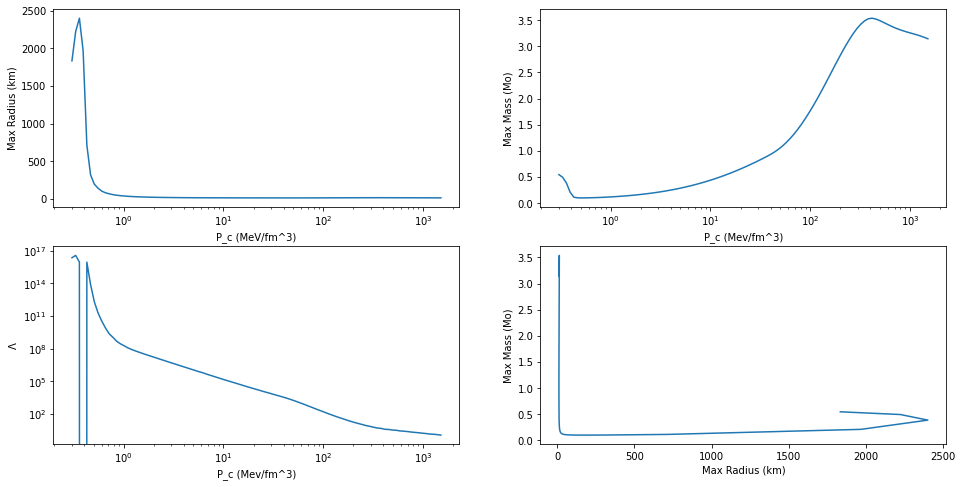

In [25]:
size = 100
start = np.log(1e-2) # start/stop for log spacing
stop = np.log(5e1)
pcs = 4e-5*np.e**(np.linspace(start, stop, size)) # central pressures in km^-2

# max p_c ~ 3000 MeV/fm^3

# we must redefine the interpolation everytime because we have def EOSs
func_e = scipy.interpolate.CubicSpline(p_1, e_1)
func_de = scipy.interpolate.CubicSpline(p_1, e_1).derivative(nu=1)

# func_e = scipy.interpolate.UnivariateSpline(p_1, e_1, k=1)
# func_de = func_e.derivative(1)

MRL_3952 = TOV_Solver(pcs, size)
np.savetxt('3952_MRcurve', MRL_3952)

C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in sqrt
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in power
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in sqrt
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in power
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
C:\Users\brend\Anaconda3\lib\site-

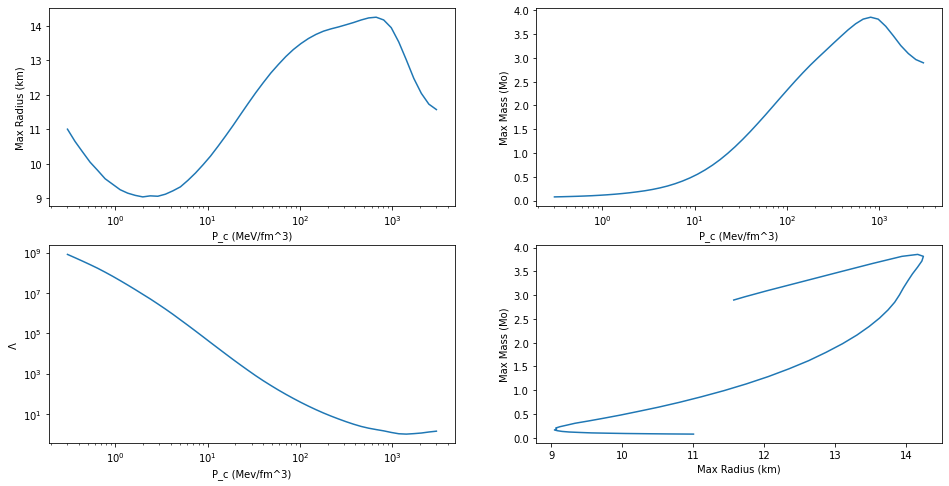

In [19]:
size = 50
start = np.log(1e-2) # start/stop for log spacing
stop = np.log(1e2)
pcs = 4e-5*np.e**(np.linspace(start, stop, size)) # central pressures in km^-2

# max p_c ~ 3000 MeV/fm^3

# we must redefine the interpolation everytime because we have def EOSs
func_e = scipy.interpolate.CubicSpline(p_2, e_2)
func_de = scipy.interpolate.CubicSpline(p_2, e_2).derivative(nu=1)

# func_e = scipy.interpolate.UnivariateSpline(p_2, e_2, k=1)
# func_de = func_e.derivative(1)

MRL_8663 = TOV_Solver(pcs, size)
np.savetxt('8663_MRcurve', MRL_8663)

C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in sqrt
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in power
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in sqrt
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in power
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
C:\Users\brend\Anaconda3\lib\site-

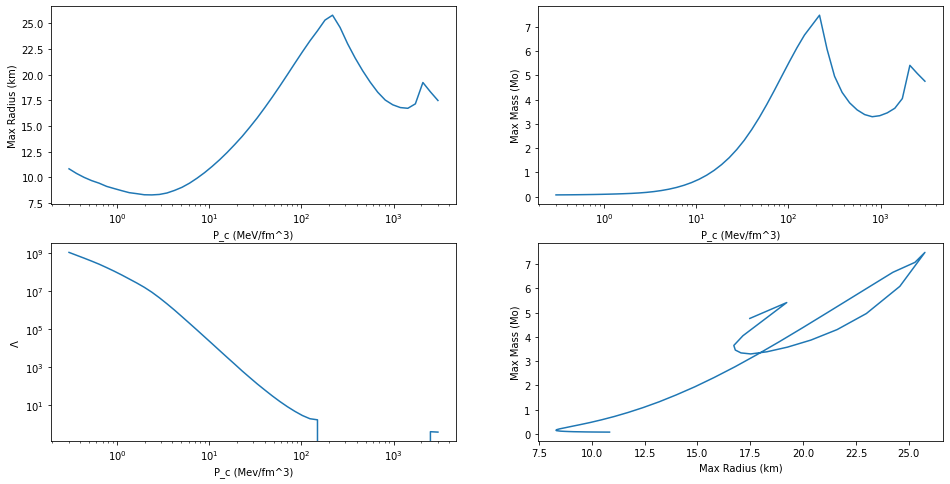

In [18]:
size = 50
start = np.log(1e-2) # start/stop for log spacing
stop = np.log(1e2)
pcs = 4e-5*np.e**(np.linspace(start, stop, size)) # central pressures in km^-2

# max p_c ~ 3000 MeV/fm^3

# we must redefine the interpolation everytime because we have def EOSs
func_e = scipy.interpolate.CubicSpline(p_3, e_3)
func_de = scipy.interpolate.CubicSpline(p_3, e_3).derivative(nu=1)

# func_e = scipy.interpolate.UnivariateSpline(p_3, e_3, k=1)
# func_de = func_e.derivative(1)

MRL_13022 = TOV_Solver(pcs, size)
np.savetxt('13022_MRcurve', MRL_13022)

In [ ]:
print(MRL_3952.shape)